In [164]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import sklearn
import pandas as pd
import scipy

from tqdm import tqdm_notebook as tqdmn

import seaborn as sns
import warnings
from PIL import Image

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from scipy.sparse import csr_matrix, isspmatrix, issparse

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from itertools import product
from sklearn.ensemble import VotingClassifier

In [4]:
#!/usr/bin/python
import os
import sys

import math
import matplotlib.image as mpimg
import numpy as np
import re

In [105]:
def get_test_statistics(true_vals,pred_vals):
    accuracy = np.sum(true_vals==pred_vals)/np.shape(pred_vals)[0]
    precision =  np.sum((true_vals==pred_vals)&(true_vals==1))/np.sum(pred_vals)
    recall =  np.sum((true_vals==pred_vals)&(true_vals==1))/np.sum(true_vals)
    f1 = 2*precision*recall/(precision+recall)
    print("Accuracy : %.3f"%(accuracy))
    print("Precision : %.3f"%(precision))
    print("Recall : %.3f"%(recall))
    print("F1-Score : %.3f"%(f1))
    print("Confusion Matrix")
    return( pd.crosstab(true_vals, pred_vals, 
                       rownames=['True'], colnames=['Predicted'], margins=True))

In [106]:
y_test_df = ytest_df.values.ravel()

In [107]:
print("Results for Negative Class")
get_test_statistics(1-y_test_df,1-full_pred)

Results for Negative Class
Accuracy : 0.716
Precision : 0.770
Recall : 0.874
F1-Score : 0.819
Confusion Matrix


Predicted,0,1,All
True,,,
0,116,300,416
1,144,1003,1147
All,260,1303,1563


In [108]:
print("Results for Negative Class")
get_test_statistics(y_test_df,full_pred)

Results for Negative Class
Accuracy : 0.716
Precision : 0.446
Recall : 0.279
F1-Score : 0.343
Confusion Matrix


Predicted,0,1,All
True,,,
0,1003,144,1147
1,300,116,416
All,1303,260,1563


In [7]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [8]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "images/groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[1])
imgs[4]
n = 10 # Only use 10 images for training




Loading 20 images
satImage_019.png
Loading 20 images
satImage_064.png


Image size = 400,400


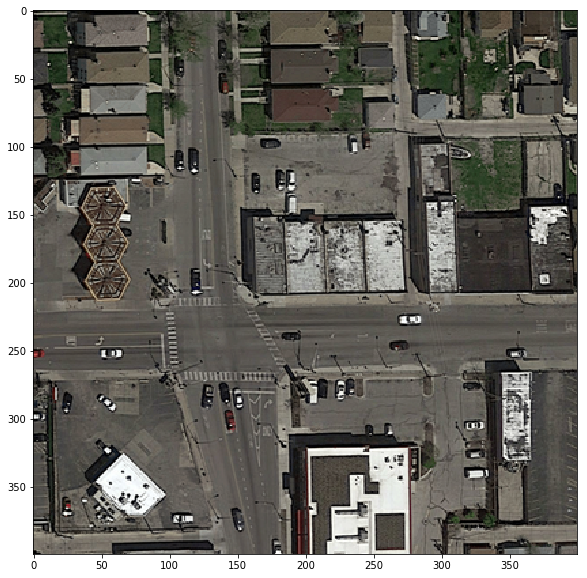

In [9]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')
plt.imshow(imgs[10])

In [10]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [11]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

In [12]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [13]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 6250 features
Feature dimension = 2
Number of classes = 1
Class 0: 4623 samples
Class 1: 1627 samples


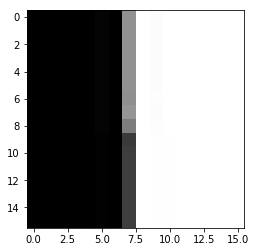

In [14]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

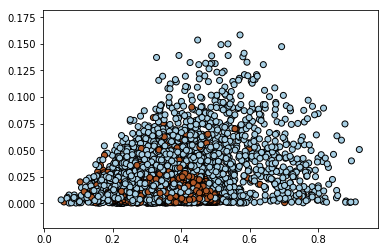

In [15]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [16]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [17]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.18512


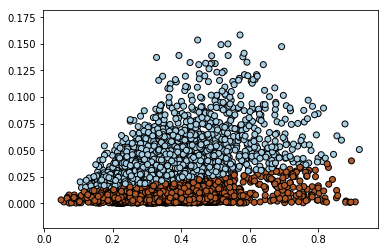

In [18]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [19]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

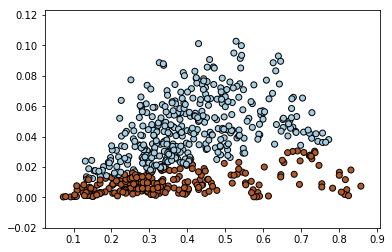

In [20]:
# Run prediction on the img_idx-th image
img_idx = 5

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

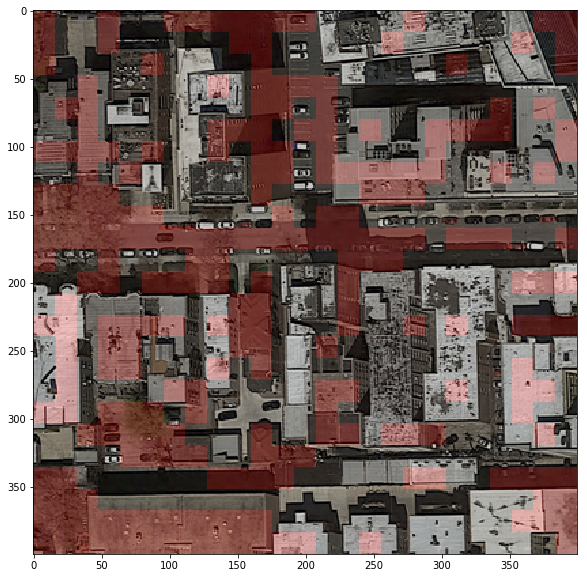

In [21]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)


In [22]:
# Random fores classifier

In [42]:
nb_samples = 80
n_estimators_set = np.random.randint(low=1,high=100,size=nb_samples)
max_depth_set = np.random.randint(low=1,high=50,size=nb_samples)

In [43]:
#RF Models hyperparameters will be optimized according to the f1-score of the positive class 
def rf_model_train(X_train,y_train,X_test,y_test,model,cv=5):
    X_train, X_test = X_train.copy(),X_test.copy()
    y_train, y_test = y_train.copy(),y_test.copy()
    nb_samples,_ = X_train.shape
    res = []
    for cv_idx in range(cv):
        idx_val = list(range(cv_idx*nb_samples//cv,(cv_idx+1)*nb_samples//cv))
        idx_train = list(set(range(nb_samples))-set(idx_val))
        X_cv_train,y_cv_train = X_train.iloc[idx_train], y_train.iloc[idx_train]
        X_cv_val,y_cv_val = X_train.iloc[idx_val], y_train.iloc[idx_val]
        y_cv_true = np.array(y_cv_val).ravel()
        y_cv_pred = model.fit(X_cv_train,y_cv_train).predict(X_cv_val)
        res.append(np.sum(y_cv_true==y_cv_pred)/np.shape(y_cv_pred)[0])
    res_mean = np.array(res).mean()
    res_std = np.array(res).std()
    return res_mean

(80,)

In [45]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y,
                                                random_state=0)

In [60]:
Xtrain_df =pd.DataFrame(Xtrain)
Xtest_df =pd.DataFrame(Xtest)
ytrain_df =pd.DataFrame(ytrain)
ytest_df =pd.DataFrame(ytest)

In [63]:

Xtrain_df_norm = (Xtrain_df-Xtrain_df.mean())/Xtrain_df.std()
Xtest_df_norm = (Xtest_df-Xtest_df.mean())/Xtest_df.std()

In [65]:
rf_model_train(Xtrain_df_norm,ytrain_df,Xtest_df_norm,ytest_df,model,cv=5)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

0.7352274304646913

In [73]:
# Automatize parameter search and return best scoring parameter (score chosen accuracy for positive class)
def grid_search_model(X_train_df,y_train_df,X_test_df,y_test_df,
                      n_estimators_set,max_depth_set):
    final_rf_res = {(est,dep): rf_model_train(Xtrain_df_norm,ytrain_df,Xtest_df_norm,ytest_df,
                                   RFC(n_estimators = est,max_depth = dep, n_jobs=-1))
                    for est,dep in tqdmn(zip(n_estimators_set,max_depth_set))}
    best_params_id = np.argmax(np.array(final_rf_res.values()))
    return list(final_rf_res.keys())[best_params_id],list(final_rf_res.values())[best_params_id]


RF_best_params, RF_best_score = grid_search_model(Xtrain_df_norm,ytrain_df,
                                                  Xtest_df_norm,ytest_df,
                                                  n_estimators_set,max_depth_set)

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/nbuser/anaconda3_420/lib/python3.5/site-packages/i

In [75]:

print("Best Params: \nMax depth %d, Nb estimators %d with 5-fold val-accuracy at %.3f"%(RF_best_params[0],
                                                      RF_best_params[1],RF_best_score))


Best Params: 
Max depth 72, Nb estimators 25 with 5-fold val-accuracy at 0.734


In [85]:

full_pred = RFC(n_estimators = RF_best_params[0],
                max_depth = RF_best_params[1]).fit(Xtrain_df_norm,ytrain_df)\
            .predict(Xtest_df_norm)
len(set(np.where(full_pred==0)[0]))

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


1303

In [32]:
def get_test_statistics(true_vals,pred_vals):
    accuracy = np.sum(true_vals==pred_vals)/np.shape(pred_vals)[0]
    precision =  np.sum((true_vals==pred_vals)&(true_vals==1))/np.sum(pred_vals)
    recall =  np.sum((true_vals==pred_vals)&(true_vals==1))/np.sum(true_vals)
    f1 = 2*precision*recall/(precision+recall)
    print("Accuracy : %.3f"%(accuracy))
    print("Precision : %.3f"%(precision))
    print("Recall : %.3f"%(recall))
    print("F1-Score : %.3f"%(f1))
    print("Confusion Matrix")
    return( pd.crosstab(true_vals, pred_vals, 
                       rownames=['True'], colnames=['Predicted']))

In [109]:
y_test_df = ytest_df.values.ravel()

In [110]:
print("Results for Negative Class")
get_test_statistics(1-y_test_df,1-full_pred)

Results for Negative Class
Accuracy : 0.716
Precision : 0.770
Recall : 0.874
F1-Score : 0.819
Confusion Matrix


Predicted,0,1,All
True,,,
0,116,300,416
1,144,1003,1147
All,260,1303,1563


In [111]:
print("Results for Positive class")
get_test_statistics(y_test_df,full_pred)

Results for Negative Class
Accuracy : 0.716
Precision : 0.446
Recall : 0.279
F1-Score : 0.343
Confusion Matrix


Predicted,0,1,All
True,,,
0,1003,144,1147
1,300,116,416
All,1303,260,1563


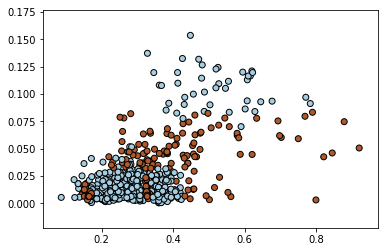

In [121]:
# Run prediction on the img_idx-th image
img_idx = 7

Xi = extract_img_features(image_dir + files[img_idx])
Zi = model.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

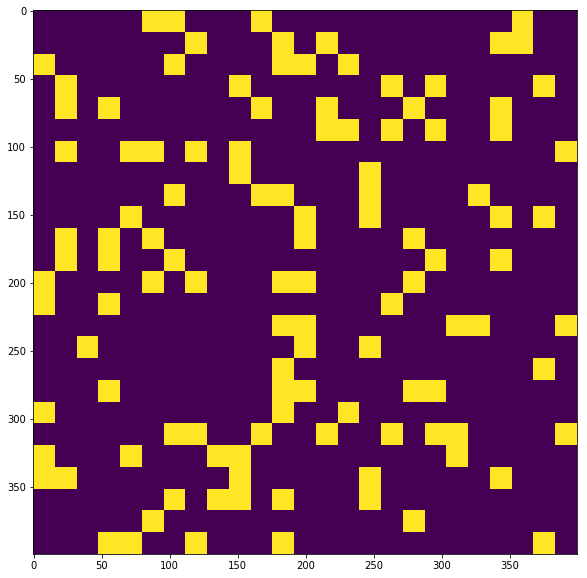

In [122]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, full_pred)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
plt.imshow(predicted_im)


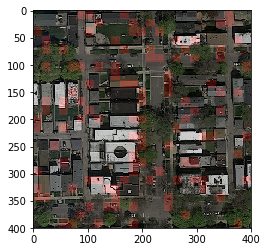

In [123]:
plt.imshow(new_img)

In [141]:
def prec_ets(n_trees, X_train, y_train, X_test, y_test, random_state=None):
    """
    ExtraTrees
    """
    from sklearn.ensemble import ExtraTreesClassifier
    if not issparse(X_train):
        X_train = X_train.reshape((X_train.shape[0], -1))
    if not issparse(X_test):
        X_test = X_test.reshape((X_test.shape[0], -1))
  
    clf = ExtraTreesClassifier(n_estimators=n_trees, max_depth=None, n_jobs=-1, verbose=1, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    prec = float(np.sum(y_pred == y_test)) / len(y_test)
   
    return clf, y_pred 

In [142]:
Xtrain_df =pd.DataFrame(Xtrain)
Xtest_df =pd.DataFrame(Xtest)
ytrain_df =pd.DataFrame(ytrain)
ytest_df =pd.DataFrame(ytest)

Xtrain_norm = (Xtrain-Xtrain.mean())/Xtrain.std()
Xtest_norm = (Xtest-Xtest.mean())/Xtest.std()

In [155]:
a, b = prec_ets(500, Xtrain_norm, ytrain, Xtest_norm, ytest, random_state=None)


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.5s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished


In [156]:
a

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [157]:
len(np.where(b==0)[0])

1282

In [158]:
len(b)

1563

In [162]:
print("Results for Positive class")
get_test_statistics(y_test_df,b)

Results for Positive class
Accuracy : 0.706
Precision : 0.423
Recall : 0.286
F1-Score : 0.341
Confusion Matrix


Predicted,0,1,All
True,,,
0,985,162,1147
1,297,119,416
All,1282,281,1563


In [161]:
print("Results for Negative Class")
get_test_statistics(1-y_test_df,1-b)

Results for Negative Class
Accuracy : 0.706
Precision : 0.768
Recall : 0.859
F1-Score : 0.811
Confusion Matrix


Predicted,0,1,All
True,,,
0,119,297,416
1,162,985,1147
All,281,1282,1563


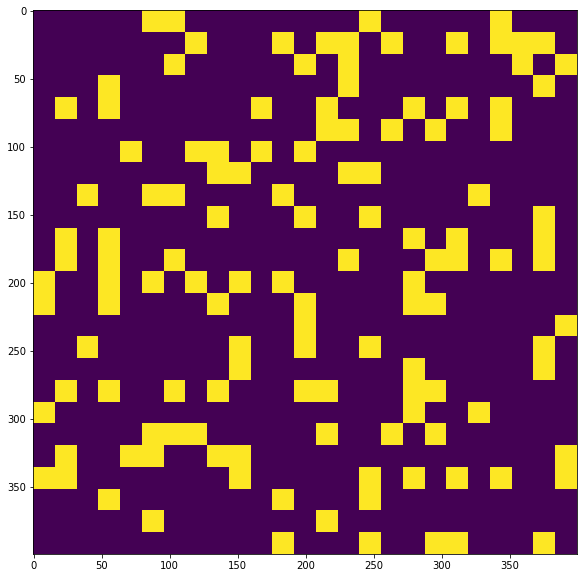

In [159]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, b)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)
plt.imshow(predicted_im)


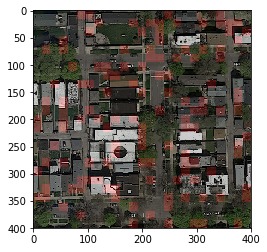

In [160]:
plt.imshow(predicted_im)
plt.imshow(new_img)

In [168]:

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma='scale', kernel='rbf', probability=True)


clf1 = clf1.fit(Xtrain_norm, ytrain)
clf2 = clf2.fit(Xtrain_norm, ytrain)
clf3 = clf3.fit(Xtrain_norm, ytrain)


TypeError: a float is required